In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

from econml.dml import CausalForestDML
from sklearn.linear_model import LassoCV

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Offline Demand

## Read data

In [109]:
data = pd.read_stata("data/online_follow-ups_data.dta")
data

,id,month,month_12,year,off2on,doc_adoption,rating_cum,online_pay_speed_p,online_pay_ln,on2off_ln,...,review_ln,article_ln,l_on2off_ln,l_online_pay_ln,l_review_ln,l_rating_cum,l_article_ln,l_online_pay_doc_num_m_ln,l_online_pay_doc_length_m_ln,l_online_pay_speed_p
0,https://www.haodf.com/doctor/110058.html,2006-12-01,12.0,2006.0,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN
1,https://www.haodf.com/doctor/234306.html,2006-12-01,12.0,2006.0,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN
2,https://www.haodf.com/doctor/6635.html,2006-12-01,12.0,2006.0,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN
3,https://www.haodf.com/doctor/5953.html,2006-11-01,11.0,2006.0,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://www.haodf.com/doctor/224317.html,2006-11-01,11.0,2006.0,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31643,https://www.haodf.com/doctor/483.html,2021-08-01,8.0,2021.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
31644,https://www.haodf.com/doctor/483.html,2021-11-01,11.0,2021.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
31645,https://www.haodf.com/doctor/483.html,2021-09-01,9.0,2021.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
31646,https://www.haodf.com/doctor/483.html,2022-01-01,1.0,2022.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0


In [110]:
data.columns

Index(['id', 'month', 'month_12', 'year', 'off2on', 'doc_adoption',
       'rating_cum', 'online_pay_speed_p', 'online_pay_ln', 'on2off_ln',
       'off2on_ln', 'online_pay_doc_length_m_ln', 'online_pay_doc_num_m_ln',
       'review_ln', 'article_ln', 'l_on2off_ln', 'l_online_pay_ln',
       'l_review_ln', 'l_rating_cum', 'l_article_ln',
       'l_online_pay_doc_num_m_ln', 'l_online_pay_doc_length_m_ln',
       'l_online_pay_speed_p'],
      dtype='object')

In [111]:
data["on2off_ln"].value_counts()

on2off_ln
0.000000    24088
0.693147      557
1.098612      253
1.386294      159
1.609438       99
1.791759       58
1.945910       44
2.079442       38
2.197225       34
2.302585       21
2.639057       18
2.484907       17
2.397895       16
2.708050       14
2.772589       13
2.564949       13
2.944439        8
3.178054        7
2.890372        7
3.135494        6
3.258096        5
3.367296        4
2.833213        4
3.526361        4
3.218876        3
3.091043        3
3.465736        3
3.828641        3
3.555348        3
3.583519        2
3.044523        2
2.995732        2
3.688879        2
3.401197        2
3.784190        2
3.988984        2
3.295837        2
4.127134        1
3.931826        1
3.951244        1
4.442651        1
4.094345        1
4.158883        1
3.737670        1
4.043051        1
3.761200        1
4.234107        1
3.891820        1
4.204693        1
3.637586        1
Name: count, dtype: int64

In [125]:
data['month_12'] = data['month_12'].astype('int')
data['year'] = data['year'].astype('int')

## Prepare data

In [126]:
used_data = data.loc[(data["year"] >= 2012) & (data["year"] <= 2017)]
used_data

,id,month,month_12,year,off2on,doc_adoption,rating_cum,online_pay_speed_p,online_pay_ln,on2off_ln,...,review_ln,article_ln,l_on2off_ln,l_online_pay_ln,l_review_ln,l_rating_cum,l_article_ln,l_online_pay_doc_num_m_ln,l_online_pay_doc_length_m_ln,l_online_pay_speed_p
4898,https://www.haodf.com/doctor/40648.html,2012-05-01,5,2012,0.0,0.0,3.916667,0.392157,1.791759,0.693147,...,0.000000,0.0,0.0,1.609438,0.000000,3.916667,0.0,0.693147,3.562465,0.243902
4899,https://www.haodf.com/doctor/283822.html,2012-12-01,12,2012,0.0,0.0,3.875000,0.909091,0.693147,0.000000,...,0.693147,0.0,0.0,1.791759,1.098612,3.863636,0.0,0.788457,4.493121,0.588235
4900,https://www.haodf.com/doctor/130919.html,2012-08-01,8,2012,0.0,0.0,3.844444,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,3.844444,0.0,0.000000,0.000000,0.000000
4901,https://www.haodf.com/doctor/74761.html,2012-05-01,5,2012,0.0,0.0,4.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,4.000000,0.0,0.000000,0.000000,0.000000
4902,https://www.haodf.com/doctor/9986.html,2012-10-01,10,2012,0.0,0.0,3.944444,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,3.944444,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31593,https://www.haodf.com/doctor/483.html,2017-04-01,4,2017,0.0,0.0,4.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,4.000000,0.0,0.000000,0.000000,0.000000
31594,https://www.haodf.com/doctor/483.html,2017-11-01,11,2017,0.0,0.0,4.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,4.000000,0.0,0.000000,0.000000,0.000000
31595,https://www.haodf.com/doctor/483.html,2017-02-01,2,2017,0.0,0.0,4.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,4.000000,0.0,0.000000,0.000000,0.000000
31596,https://www.haodf.com/doctor/483.html,2017-10-01,10,2017,0.0,0.0,4.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,4.000000,0.0,0.000000,0.000000,0.000000


In [127]:
treatment = ['doc_adoption']
outcome = ['on2off_ln']
covariates = ["l_online_pay_ln", "l_review_ln", "l_rating_cum", "l_article_ln", "month_12", "year"]

In [128]:
all_variables = treatment + outcome + covariates
used_data.dropna(axis=0, subset=all_variables, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [129]:
# split data into train and test sets 
train, test = train_test_split(used_data, test_size=0.2)

# set variables for causal forest Y=outcome, T=treatment, X=covariates, W=effect_modifiers 
Y = train[outcome].values
T = train[treatment].values
X = train[covariates]
X = pd.get_dummies(X, columns=['month_12', 'year'], drop_first=True).values # Convert categorical variables to dummy variables if necessary
W = None

# test set
X_test = test[covariates]
X_test = pd.get_dummies(X_test, columns=['month_12', 'year'], drop_first=True).values

In [130]:
X

array([[0.6931471824645996, 0.0, 3.7928571701049805, ..., False, False,
        True],
       [0.0, 0.0, 4.0, ..., False, False, False],
       [0.0, 0.0, 3.9583334922790527, ..., False, False, False],
       ...,
       [0.0, 0.6931471824645996, 3.875, ..., True, False, False],
       [0.0, 0.0, 3.857142925262451, ..., False, False, False],
       [2.079441547393799, 0.0, 3.9166665077209473, ..., True, False,
        False]], dtype=object)

## Build model

In [131]:
# set parameters for causal forest 
causal_forest = CausalForestDML(criterion='het', # Measure the quality of a split, het for heterogeneity score
                                n_estimators=10000, # Number of trees
                                min_samples_leaf=10, # The minimum number of samples required to be at a leaf node
                                max_depth=None, # Maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples
                                max_samples=0.5, # The number of samples to use for each subsample that is used to train each tree
                                discrete_treatment=True, # Whether the treatment values should be treated as categorical
                                discrete_outcome=False,
                                honest=True, # Whether each tree should be trained in an honest manner, i.e. the training set is split into two equal sized subsets, the train and the val set. All samples in train are used to create the split structure and all samples in val are used to calculate the value of each node in the tree.
                                inference=True, #  Whether inference (i.e. confidence interval construction and uncertainty quantification of the estimates) should be enabled. If inference=True, then the estimator uses a bootstrap-of-little-bags approach to calculate the covariance of the parameter vector, with am objective Bayesian debiasing correction to ensure that variance quantities are positive.
                                cv=10, # Cross-validation splitting strategy
                                model_t=LassoCV(), # How to fit the treatment to the features 
                                model_y=LassoCV(), # How to fit the outcome to the features
                                )
                      
# fit train data to causal forest model 
causal_forest.fit(Y, T, X=X, W=W, cache_values=True)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
First stage model has discrete target but model is not a classifier!
First stage model has discrete target but model is not a classifier!
First stage model has discrete target but model is not a classifier!
First stage model has discrete target but model is not a classifier!
First stage model has discrete target but model is not a classifier!
First stage model has discrete target but model is not a classifier!
First stage model has discrete target but model is not a classifier!
First stage model has discrete target but model is not a classifier!
First stage model has discrete target but model is not a classifier!
First stage model has discrete target but model is not a classifier!


In [132]:
# estimate the CATE with the test set 
causal_forest.const_marginal_ate(X_test)

array([[0.0666255]])

In [135]:
# Calculate the heterogeneous treatment effect 
treatment_effects = causal_forest.effect(X_test)

# Calculate default (95%) confidence intervals for the default treatment points T0=0 and T1=1
te_lower, te_upper = causal_forest.effect_interval(X_test)

In [136]:
# Average heterogeneous treatment effect
np.mean(treatment_effects)

0.06662550045266989

In [139]:
len(causal_forest.feature_importances_.flatten())

20

In [141]:
pd.get_dummies(train[covariates], columns=['month_12', 'year'], drop_first=True).columns

Index(['l_online_pay_ln', 'l_review_ln', 'l_rating_cum', 'l_article_ln',
       'month_12_2', 'month_12_3', 'month_12_4', 'month_12_5', 'month_12_6',
       'month_12_7', 'month_12_8', 'month_12_9', 'month_12_10', 'month_12_11',
       'month_12_12', 'year_2013', 'year_2014', 'year_2015', 'year_2016',
       'year_2017'],
      dtype='object')

In [142]:
# Get feature importances
importances = causal_forest.feature_importances_.flatten()

# Create a DataFrame for better visualization
feature_names = ['l_online_pay_ln', 'l_review_ln', 'l_rating_cum', 'l_article_ln',
       'month_12_2', 'month_12_3', 'month_12_4', 'month_12_5', 'month_12_6',
       'month_12_7', 'month_12_8', 'month_12_9', 'month_12_10', 'month_12_11',
       'month_12_12', 'year_2013', 'year_2014', 'year_2015', 'year_2016',
       'year_2017']
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

            Feature  Importance
0   l_online_pay_ln    0.341806
2      l_rating_cum    0.267414
1       l_review_ln    0.193251
17        year_2015    0.104786
18        year_2016    0.026472
19        year_2017    0.018614
3      l_article_ln    0.011929
5        month_12_3    0.010487
4        month_12_2    0.005318
15        year_2013    0.004161
14      month_12_12    0.003037
12      month_12_10    0.002645
16        year_2014    0.002094
6        month_12_4    0.002037
9        month_12_7    0.001395
13      month_12_11    0.001338
10       month_12_8    0.001267
11       month_12_9    0.001019
8        month_12_6    0.000490
7        month_12_5    0.000440


In [143]:
causal_forest.summary()

Population summary of CATE predictions on Training Data


<class 'econml.utilities.Summary'>
"""
               Uncertainty of Mean Point Estimate              
===============================================================
mean_point stderr_mean zstat pvalue ci_mean_lower ci_mean_upper
---------------------------------------------------------------
     0.068       0.061 1.125  0.261        -0.051         0.188
      Distribution of Point Estimate     
=========================================
std_point pct_point_lower pct_point_upper
-----------------------------------------
    0.102          -0.043           0.355
     Total Variance of Point Estimate     
==========================================
stderr_point ci_point_lower ci_point_upper
------------------------------------------
       0.118         -0.067          0.406
       Doubly Robust ATE on Training Data Results       
========================================================
    point_estimate stderr zstat pvalue ci_lower ci_upper
--------------------------------------------------------
ATE          0.059  0.009  6.55    0.0    0.041    0.077
     Doubly Robust ATT(T=0) on Training Data Results     
=========================================================
    point_estimate stderr zstat  pvalue ci_lower ci_upper
---------------------------------------------------------
ATT          0.078  0.005 15.301    0.0    0.068    0.088
    Doubly Robust ATT(T=1) on Training Data Results     
========================================================
    point_estimate stderr zstat pvalue ci_lower ci_upper
--------------------------------------------------------
ATT          0.007  0.032 0.214   0.83   -0.055    0.069
--------------------------------------------------------

Note: The stderr_mean is a conservative upper bound.
"""

## Plot results

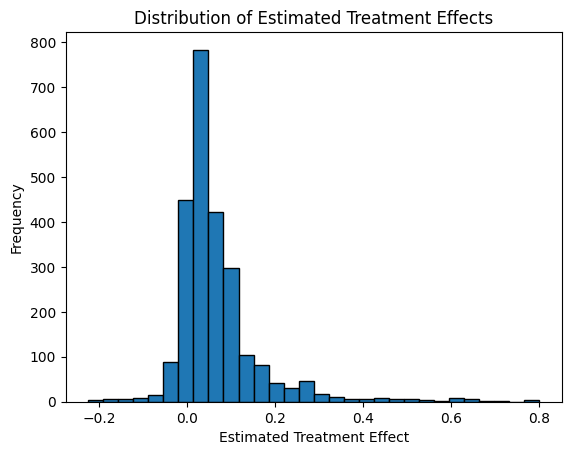

In [144]:
import matplotlib.pyplot as plt
plt.hist(treatment_effects, bins=30, edgecolor='k')
plt.title('Distribution of Estimated Treatment Effects')
plt.xlabel('Estimated Treatment Effect')
plt.ylabel('Frequency')
plt.show()

In [146]:
covariates = ['l_online_pay_ln', 'l_review_ln', 'l_rating_cum', 'l_article_ln',
       'month_12_2', 'month_12_3', 'month_12_4', 'month_12_5', 'month_12_6',
       'month_12_7', 'month_12_8', 'month_12_9', 'month_12_10', 'month_12_11',
       'month_12_12', 'year_2013', 'year_2014', 'year_2015', 'year_2016',
       'year_2017']

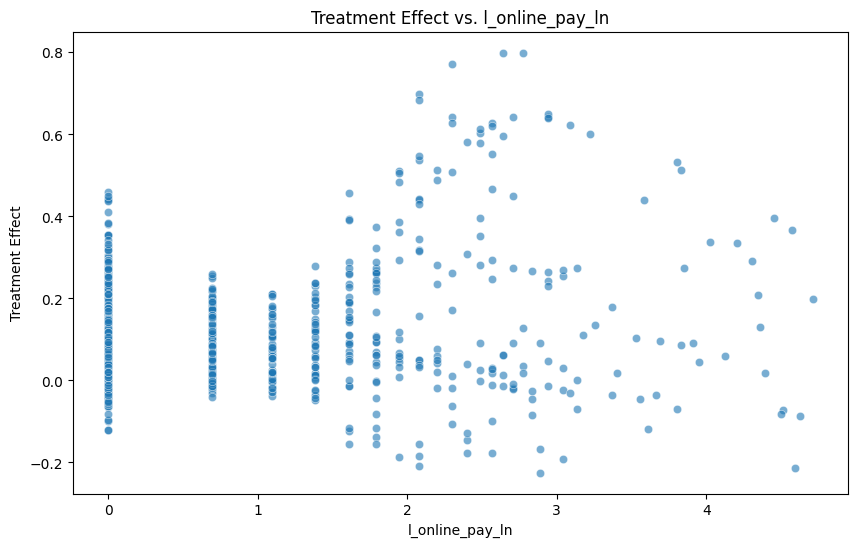

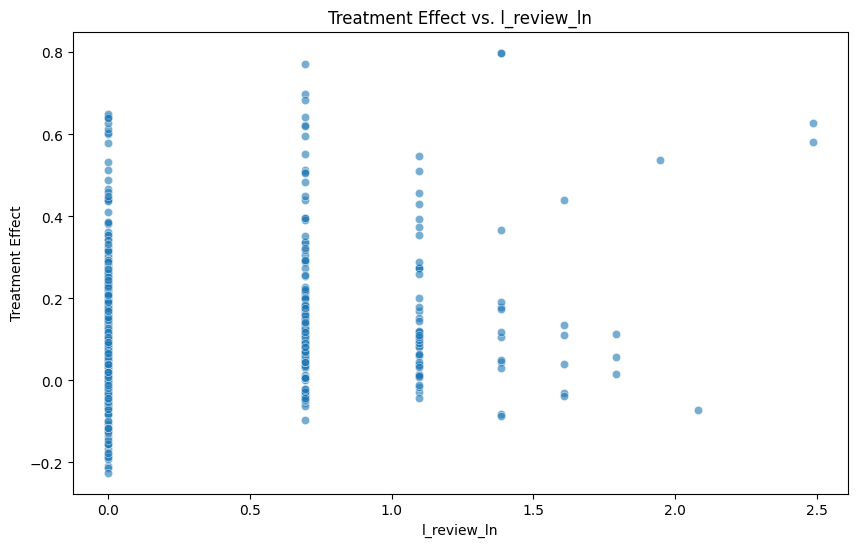

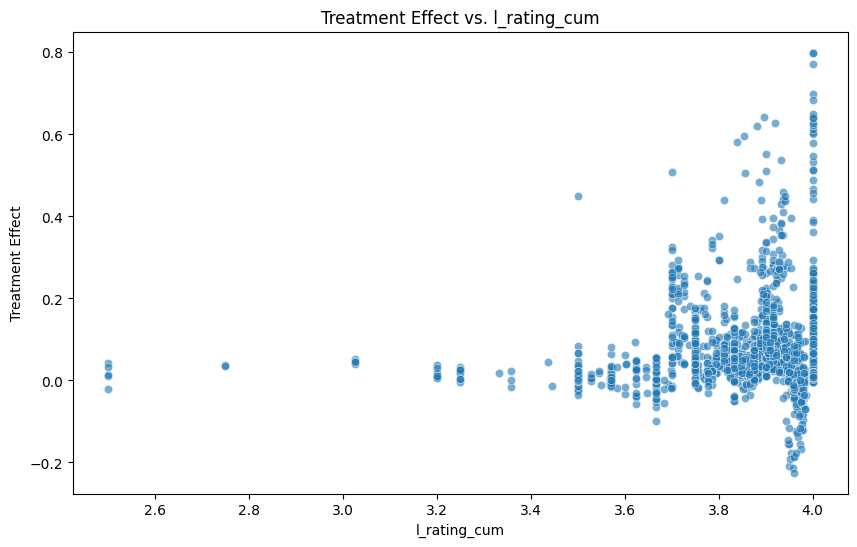

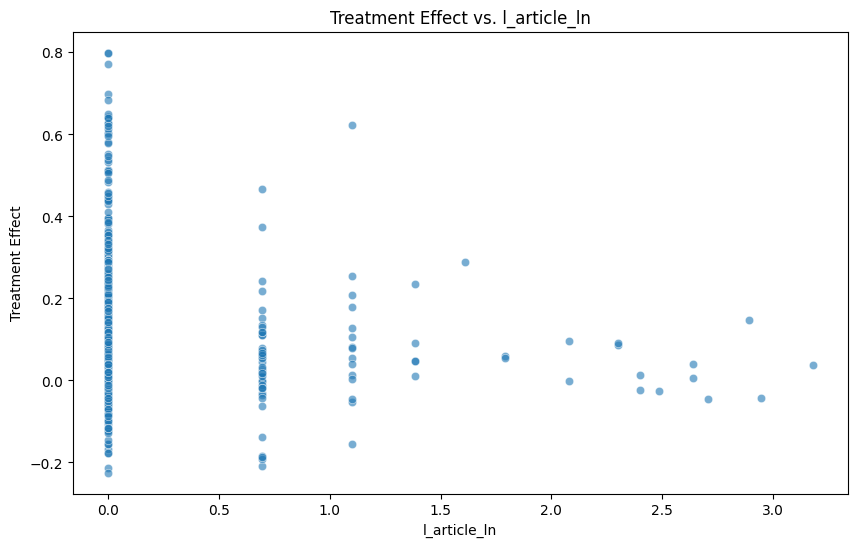

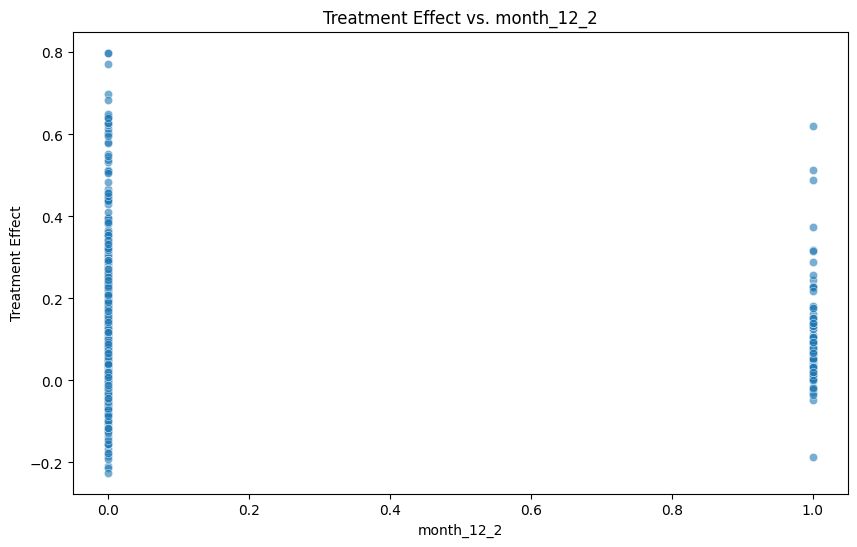

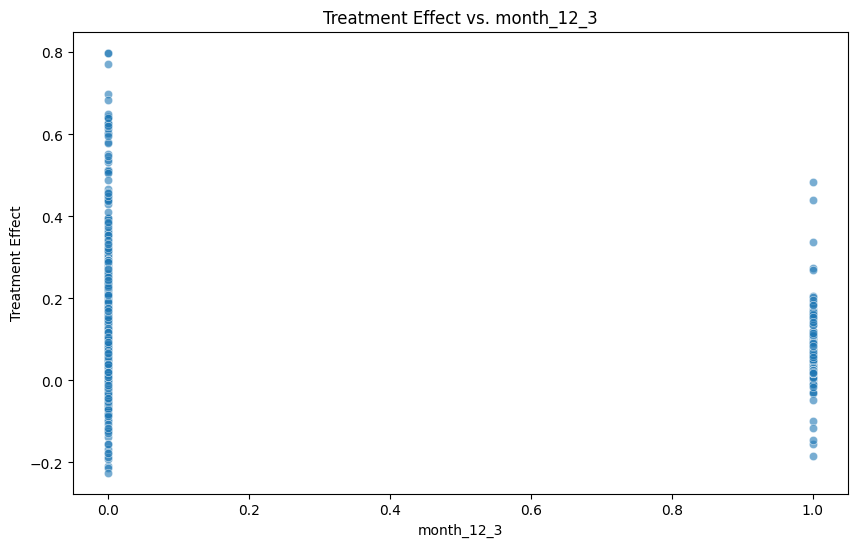

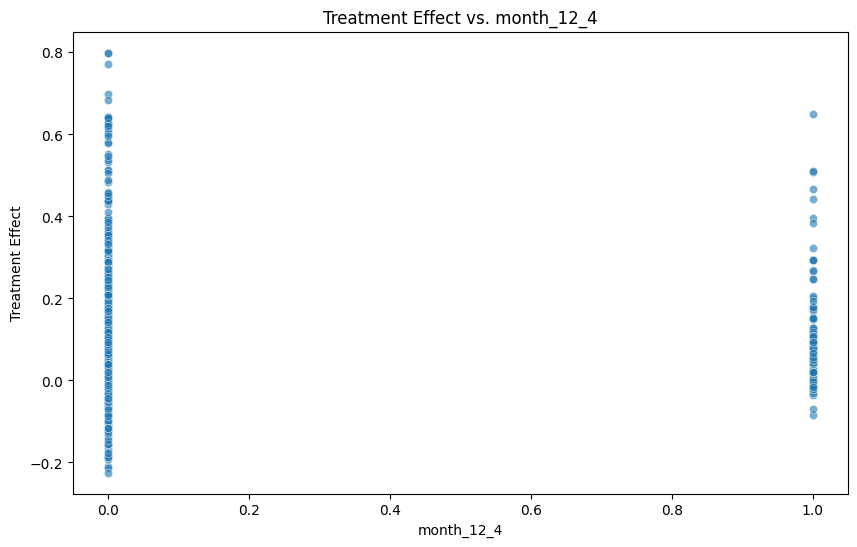

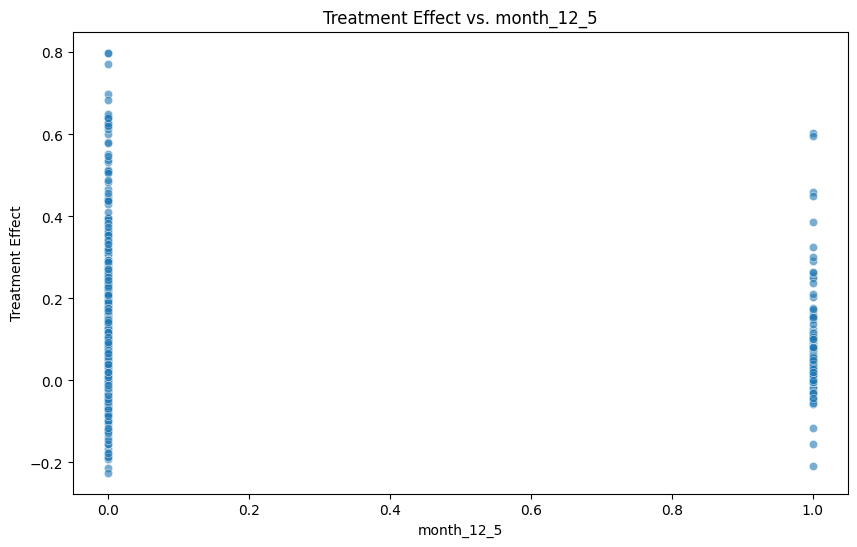

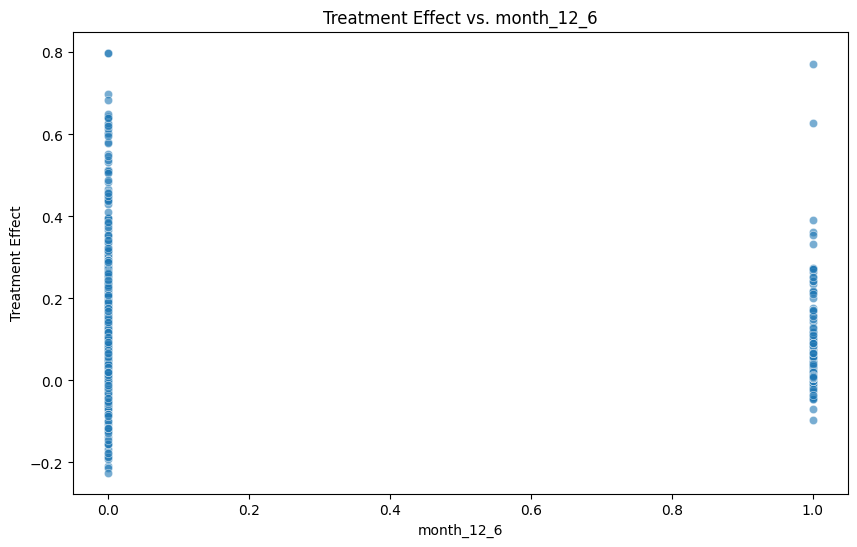

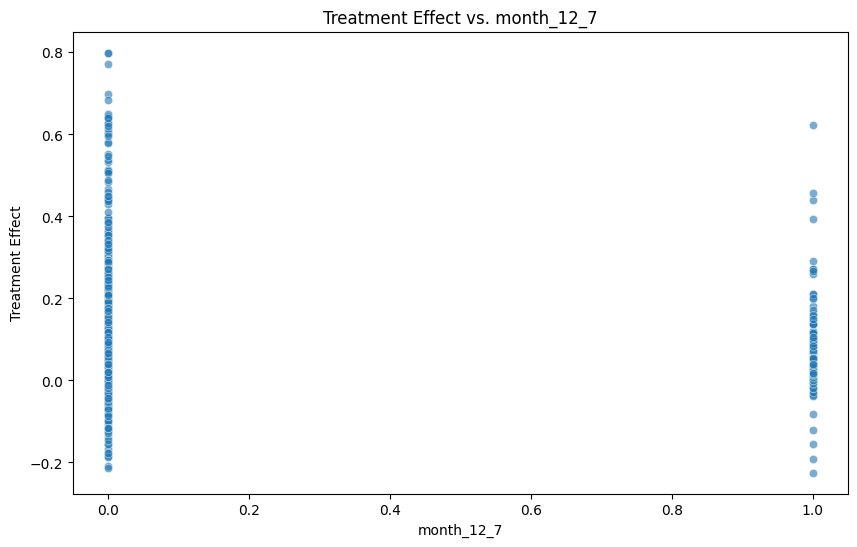

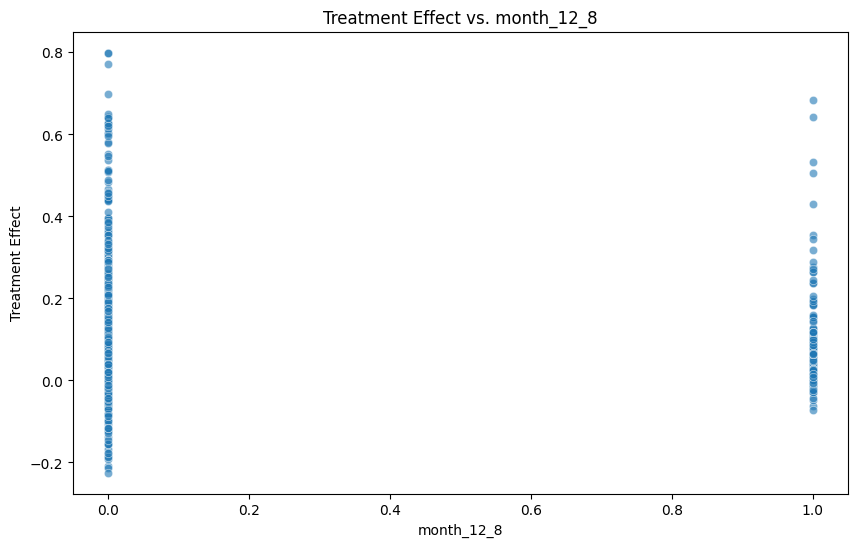

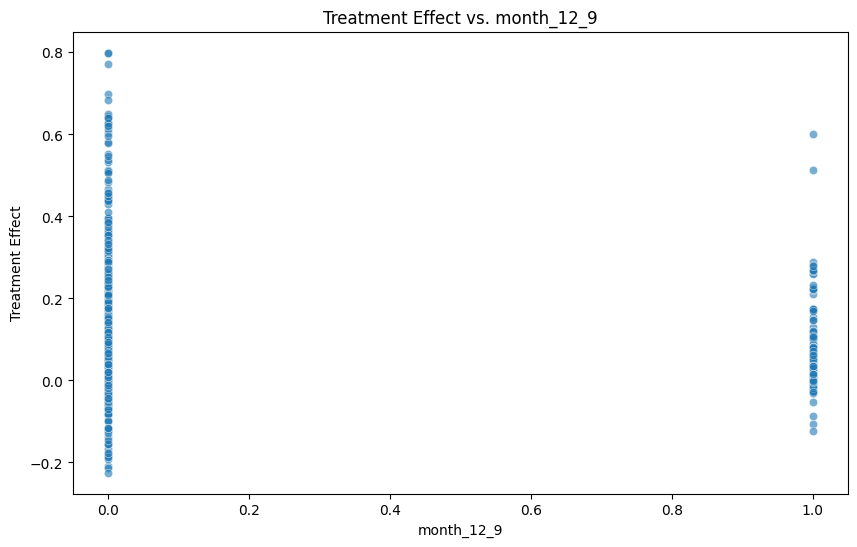

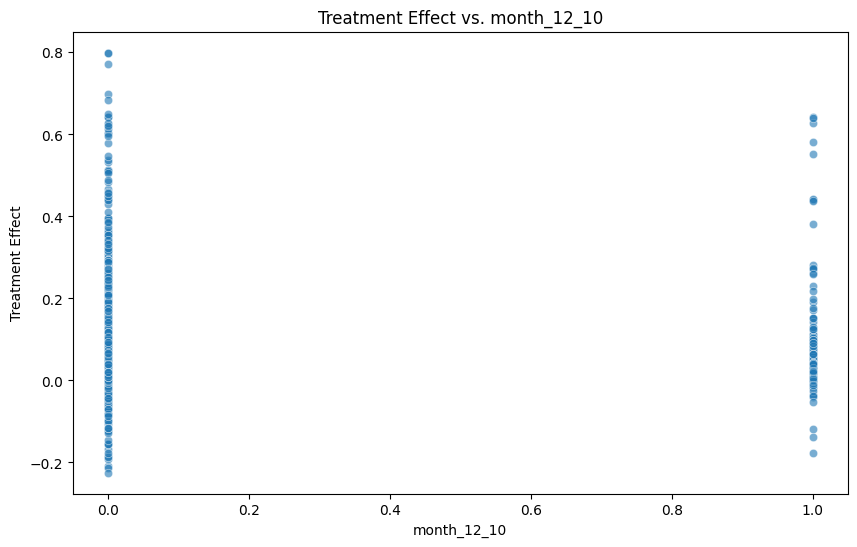

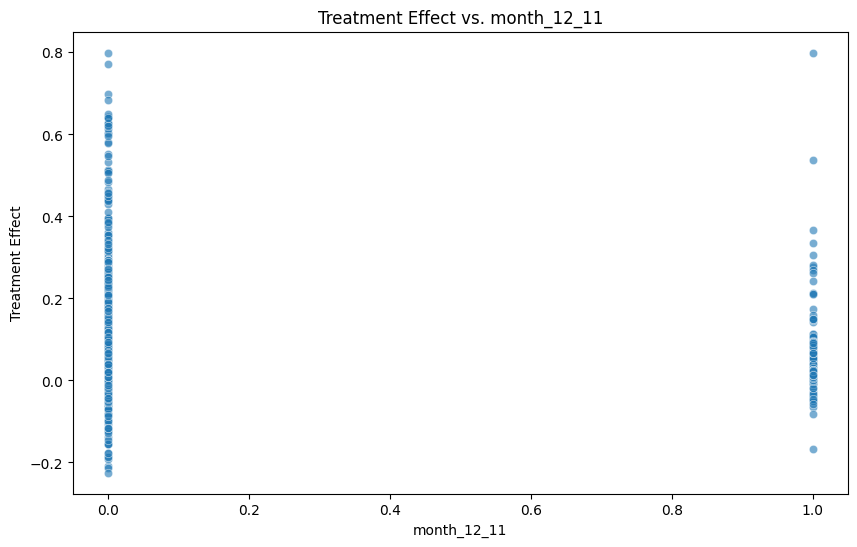

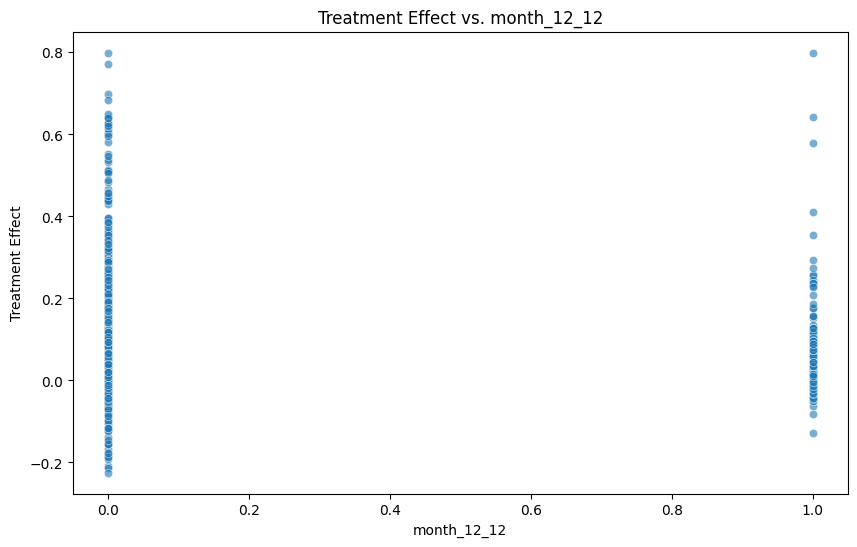

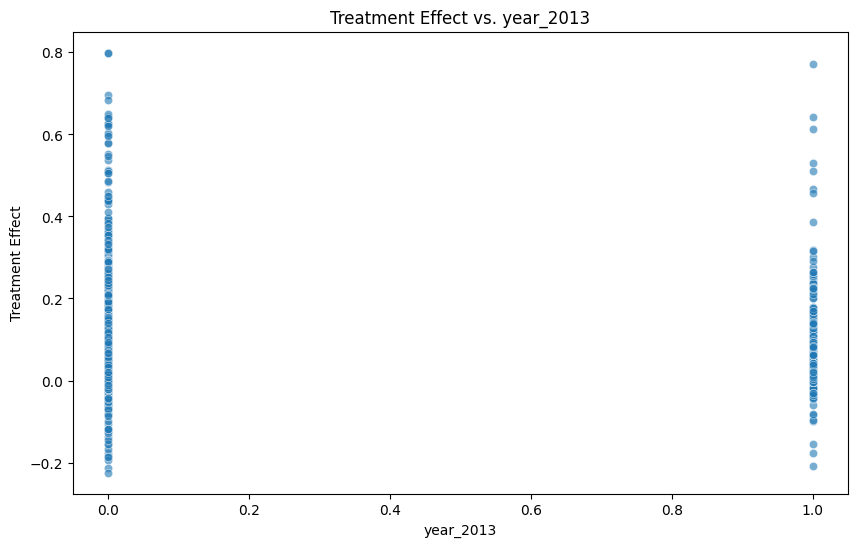

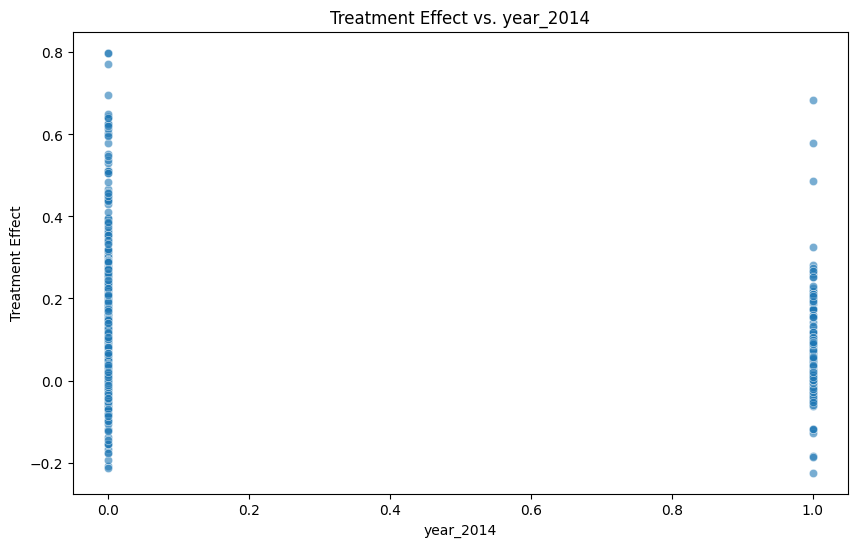

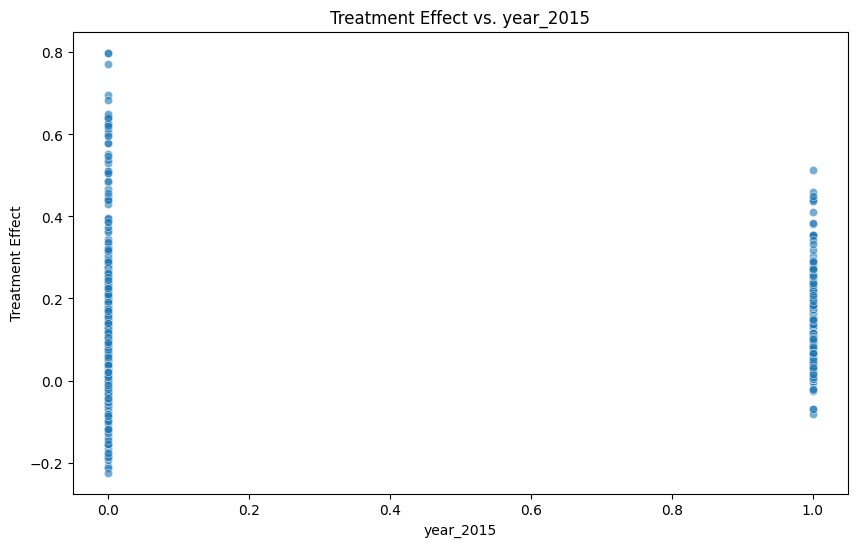

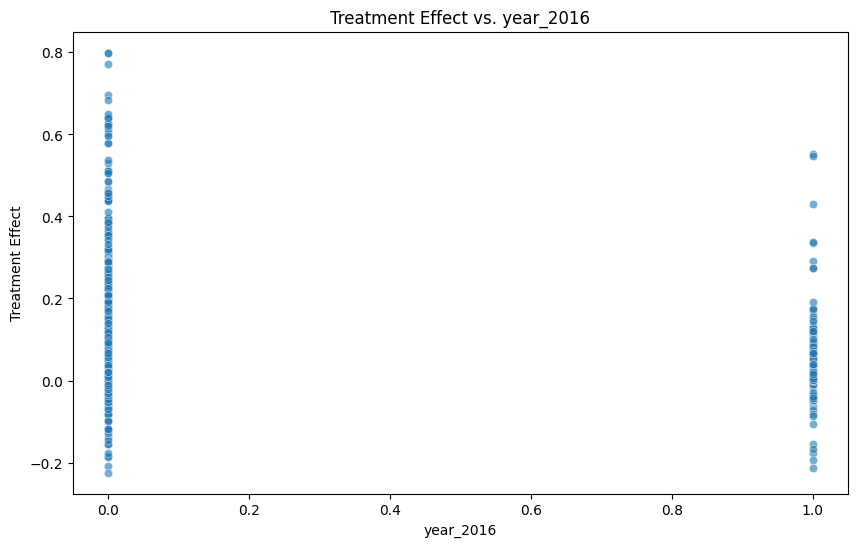

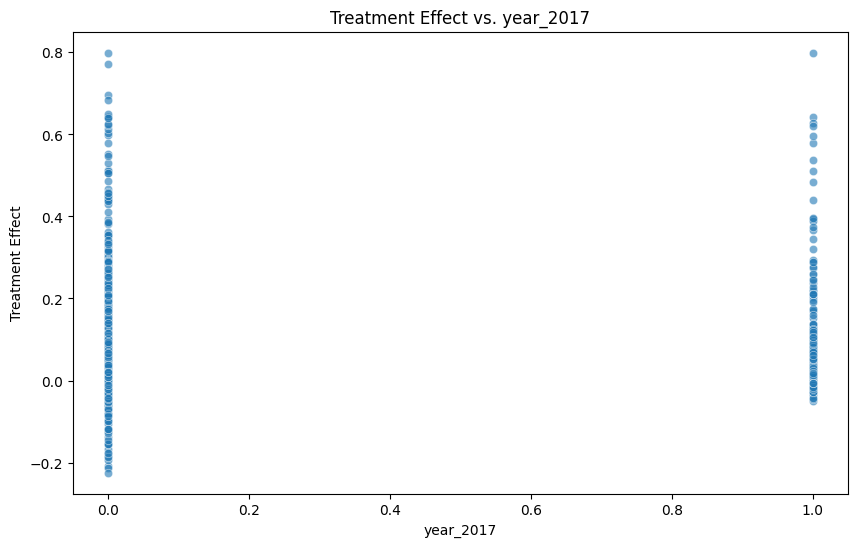

In [147]:
# Create a DataFrame for plotting
plot_data = pd.DataFrame(X_test, columns=covariates)
plot_data['Treatment Effect'] = treatment_effects
plot_data["doc_adoption"] = test["doc_adoption"].values
plot_data["year"] = test["year"].values
plot_data["month"] = test["month_12"].values

# Scatter plot for each covariate
for covariate in covariates:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=plot_data, x=covariate, y='Treatment Effect', alpha=0.6)
    plt.title(f'Treatment Effect vs. {covariate}')
    plt.xlabel(covariate)
    plt.ylabel('Treatment Effect')
    plt.show()


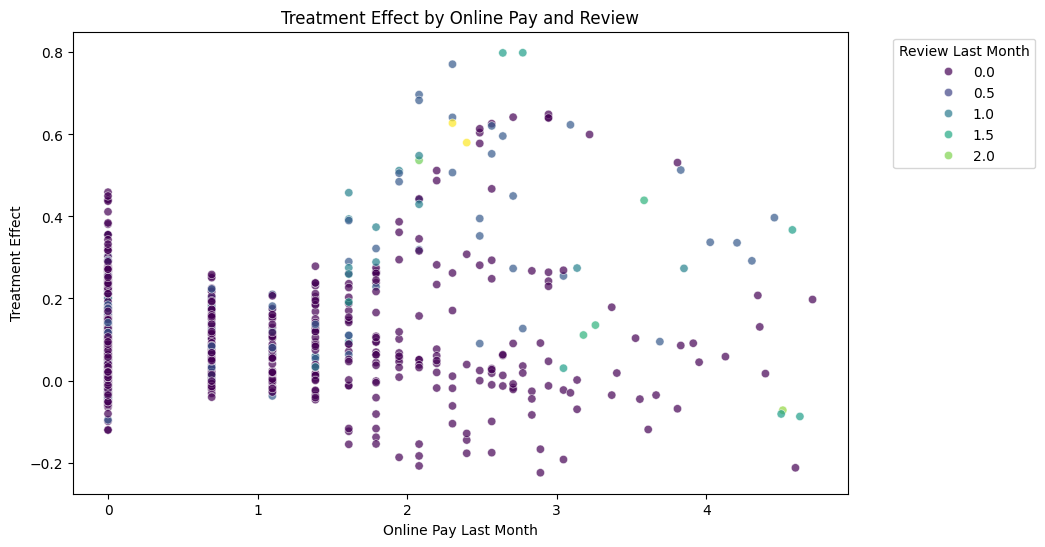

In [151]:
# Example: Interaction between 'l_review_ln' and 'l_online_pay_ln'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_data, x='l_online_pay_ln', y='Treatment Effect', hue='l_review_ln', palette='viridis', alpha=0.7)
plt.title('Treatment Effect by Online Pay and Review')
plt.xlabel('Online Pay Last Month')
plt.ylabel('Treatment Effect')
plt.legend(title='Review Last Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Online Demand

## Read data

In [2]:
data = pd.read_stata("data/online_follow-ups_data.dta")
data

,id,month,month_12,year,off2on,doc_adoption,rating_cum,online_pay_speed_p,online_pay_ln,on2off_ln,...,review_ln,article_ln,l_on2off_ln,l_online_pay_ln,l_review_ln,l_rating_cum,l_article_ln,l_online_pay_doc_num_m_ln,l_online_pay_doc_length_m_ln,l_online_pay_speed_p
0,https://www.haodf.com/doctor/110058.html,2006-12-01,12.0,2006.0,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN
1,https://www.haodf.com/doctor/234306.html,2006-12-01,12.0,2006.0,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN
2,https://www.haodf.com/doctor/6635.html,2006-12-01,12.0,2006.0,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN
3,https://www.haodf.com/doctor/5953.html,2006-11-01,11.0,2006.0,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://www.haodf.com/doctor/224317.html,2006-11-01,11.0,2006.0,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31643,https://www.haodf.com/doctor/483.html,2021-08-01,8.0,2021.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
31644,https://www.haodf.com/doctor/483.html,2021-11-01,11.0,2021.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
31645,https://www.haodf.com/doctor/483.html,2021-09-01,9.0,2021.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
31646,https://www.haodf.com/doctor/483.html,2022-01-01,1.0,2022.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0


In [3]:
data.columns

Index(['id', 'month', 'month_12', 'year', 'off2on', 'doc_adoption',
       'rating_cum', 'online_pay_speed_p', 'online_pay_ln', 'on2off_ln',
       'off2on_ln', 'online_pay_doc_length_m_ln', 'online_pay_doc_num_m_ln',
       'review_ln', 'article_ln', 'l_on2off_ln', 'l_online_pay_ln',
       'l_review_ln', 'l_rating_cum', 'l_article_ln',
       'l_online_pay_doc_num_m_ln', 'l_online_pay_doc_length_m_ln',
       'l_online_pay_speed_p'],
      dtype='object')

In [4]:
data["online_pay_ln"].value_counts()

online_pay_ln
0.000000    19781
0.693147     1483
1.098612      854
1.386294      577
1.609438      438
            ...  
4.736198        1
4.976734        1
4.465908        1
5.017280        1
5.332719        1
Name: count, Length: 123, dtype: int64

In [5]:
data['month_12'] = data['month_12'].astype('int')
data['year'] = data['year'].astype('int')

## Prepare data

In [6]:
used_data = data.loc[(data["year"] >= 2012) & (data["year"] <= 2017)]
used_data

,id,month,month_12,year,off2on,doc_adoption,rating_cum,online_pay_speed_p,online_pay_ln,on2off_ln,...,review_ln,article_ln,l_on2off_ln,l_online_pay_ln,l_review_ln,l_rating_cum,l_article_ln,l_online_pay_doc_num_m_ln,l_online_pay_doc_length_m_ln,l_online_pay_speed_p
4898,https://www.haodf.com/doctor/40648.html,2012-05-01,5,2012,0.0,0.0,3.916667,0.392157,1.791759,0.693147,...,0.000000,0.0,0.0,1.609438,0.000000,3.916667,0.0,0.693147,3.562465,0.243902
4899,https://www.haodf.com/doctor/283822.html,2012-12-01,12,2012,0.0,0.0,3.875000,0.909091,0.693147,0.000000,...,0.693147,0.0,0.0,1.791759,1.098612,3.863636,0.0,0.788457,4.493121,0.588235
4900,https://www.haodf.com/doctor/130919.html,2012-08-01,8,2012,0.0,0.0,3.844444,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,3.844444,0.0,0.000000,0.000000,0.000000
4901,https://www.haodf.com/doctor/74761.html,2012-05-01,5,2012,0.0,0.0,4.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,4.000000,0.0,0.000000,0.000000,0.000000
4902,https://www.haodf.com/doctor/9986.html,2012-10-01,10,2012,0.0,0.0,3.944444,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,3.944444,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31593,https://www.haodf.com/doctor/483.html,2017-04-01,4,2017,0.0,0.0,4.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,4.000000,0.0,0.000000,0.000000,0.000000
31594,https://www.haodf.com/doctor/483.html,2017-11-01,11,2017,0.0,0.0,4.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,4.000000,0.0,0.000000,0.000000,0.000000
31595,https://www.haodf.com/doctor/483.html,2017-02-01,2,2017,0.0,0.0,4.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,4.000000,0.0,0.000000,0.000000,0.000000
31596,https://www.haodf.com/doctor/483.html,2017-10-01,10,2017,0.0,0.0,4.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,4.000000,0.0,0.000000,0.000000,0.000000


In [7]:
treatment = ['doc_adoption']
outcome = ['online_pay_ln']
covariates = ["l_online_pay_doc_num_m_ln", "l_online_pay_doc_length_m_ln", "l_online_pay_speed_p", "l_on2off_ln", "l_review_ln","l_rating_cum", "l_article_ln", "month_12", "year"]

In [8]:
all_variables = treatment + outcome + covariates
used_data.dropna(axis=0, subset=all_variables, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
# split data into train and test sets 
train, test = train_test_split(used_data, test_size=0.2)

# set variables for causal forest Y=outcome, T=treatment, X=covariates, W=effect_modifiers 
Y = train[outcome].values
T = train[treatment].values
X = train[covariates]
X = pd.get_dummies(X, columns=['month_12', 'year'], drop_first=True).values # Convert categorical variables to dummy variables if necessary
W = None

# test set
X_test = test[covariates]
X_test = pd.get_dummies(X_test, columns=['month_12', 'year'], drop_first=True).values

## Build model

In [10]:
# set parameters for causal forest 
causal_forest = CausalForestDML(criterion='het', # Measure the quality of a split, het for heterogeneity score
                                n_estimators=10000, # Number of trees
                                min_samples_leaf=10, # The minimum number of samples required to be at a leaf node
                                max_depth=None, # Maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples
                                max_samples=0.5, # The number of samples to use for each subsample that is used to train each tree
                                discrete_treatment=True, # Whether the treatment values should be treated as categorical
                                discrete_outcome=False,
                                honest=True, # Whether each tree should be trained in an honest manner, i.e. the training set is split into two equal sized subsets, the train and the val set. All samples in train are used to create the split structure and all samples in val are used to calculate the value of each node in the tree.
                                inference=True, #  Whether inference (i.e. confidence interval construction and uncertainty quantification of the estimates) should be enabled. If inference=True, then the estimator uses a bootstrap-of-little-bags approach to calculate the covariance of the parameter vector, with am objective Bayesian debiasing correction to ensure that variance quantities are positive.
                                cv=10, # Cross-validation splitting strategy
                                model_t=LassoCV(), # How to fit the treatment to the features 
                                model_y=LassoCV(), # How to fit the outcome to the features
                                )
                      
# fit train data to causal forest model 
causal_forest.fit(Y, T, X=X, W=W, cache_values=True)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
First stage model has discrete target but model is not a classifier!
First stage model has discrete target but model is not a classifier!
First stage model has discrete target but model is not a classifier!
First stage model has discrete target but model is not a classifier!
First stage model has discrete target but model is not a classifier!
First stage model has discrete target but model is not a classifier!
First stage model has discrete target but model is not a classifier!
First stage model has discrete target but model is not a classifier!
First stage model has discrete target but model is not a classifier!
First stage model has discrete target but model is not a classifier!


In [11]:
# estimate the CATE with the test set 
causal_forest.const_marginal_ate(X_test)

array([[0.06785838]])

In [12]:
# Calculate the heterogeneous treatment effect 
treatment_effects = causal_forest.effect(X_test)

# Calculate default (95%) confidence intervals for the default treatment points T0=0 and T1=1
te_lower, te_upper = causal_forest.effect_interval(X_test)

In [13]:
# Average heterogeneous treatment effect
np.mean(treatment_effects)

0.0678583771141965

In [14]:
len(causal_forest.feature_importances_.flatten())

23

In [15]:
pd.get_dummies(train[covariates], columns=['month_12', 'year'], drop_first=True).columns

Index(['l_online_pay_doc_num_m_ln', 'l_online_pay_doc_length_m_ln',
       'l_online_pay_speed_p', 'l_on2off_ln', 'l_review_ln', 'l_rating_cum',
       'l_article_ln', 'month_12_2', 'month_12_3', 'month_12_4', 'month_12_5',
       'month_12_6', 'month_12_7', 'month_12_8', 'month_12_9', 'month_12_10',
       'month_12_11', 'month_12_12', 'year_2013', 'year_2014', 'year_2015',
       'year_2016', 'year_2017'],
      dtype='object')

In [16]:
# Get feature importances
importances = causal_forest.feature_importances_.flatten()

# Create a DataFrame for better visualization
feature_names = ['l_online_pay_doc_num_m_ln', 'l_online_pay_doc_length_m_ln',
       'l_online_pay_speed_p', 'l_on2off_ln', 'l_review_ln', 'l_rating_cum',
       'l_article_ln', 'month_12_2', 'month_12_3', 'month_12_4', 'month_12_5',
       'month_12_6', 'month_12_7', 'month_12_8', 'month_12_9', 'month_12_10',
       'month_12_11', 'month_12_12', 'year_2013', 'year_2014', 'year_2015',
       'year_2016', 'year_2017']
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                         Feature  Importance
2           l_online_pay_speed_p    0.382414
1   l_online_pay_doc_length_m_ln    0.213474
0      l_online_pay_doc_num_m_ln    0.153924
5                   l_rating_cum    0.120775
6                   l_article_ln    0.032030
20                     year_2015    0.015372
21                     year_2016    0.010769
4                    l_review_ln    0.010077
18                     year_2013    0.009102
19                     year_2014    0.008674
22                     year_2017    0.006127
17                   month_12_12    0.006007
8                     month_12_3    0.005656
15                   month_12_10    0.004618
16                   month_12_11    0.003699
3                    l_on2off_ln    0.003445
7                     month_12_2    0.002943
10                    month_12_5    0.002262
14                    month_12_9    0.002225
13                    month_12_8    0.002083
9                     month_12_4    0.002033
11        

In [17]:
causal_forest.summary()

Population summary of CATE predictions on Training Data


<class 'econml.utilities.Summary'>
"""
               Uncertainty of Mean Point Estimate              
===============================================================
mean_point stderr_mean zstat pvalue ci_mean_lower ci_mean_upper
---------------------------------------------------------------
     0.068       0.121 0.561  0.575        -0.169         0.304
      Distribution of Point Estimate     
=========================================
std_point pct_point_lower pct_point_upper
-----------------------------------------
    0.153          -0.223           0.461
     Total Variance of Point Estimate     
==========================================
stderr_point ci_point_lower ci_point_upper
------------------------------------------
       0.195         -0.288          0.573
       Doubly Robust ATE on Training Data Results       
========================================================
    point_estimate stderr zstat pvalue ci_lower ci_upper
--------------------------------------------------------
ATE          0.004   0.03 0.131  0.895   -0.055    0.063
    Doubly Robust ATT(T=0) on Training Data Results     
========================================================
    point_estimate stderr zstat pvalue ci_lower ci_upper
--------------------------------------------------------
ATT          0.047  0.031 1.536  0.125   -0.013    0.108
     Doubly Robust ATT(T=1) on Training Data Results     
=========================================================
    point_estimate stderr zstat  pvalue ci_lower ci_upper
---------------------------------------------------------
ATT         -0.118  0.076 -1.552  0.121   -0.267    0.031
---------------------------------------------------------

Note: The stderr_mean is a conservative upper bound.
"""

## Plot results

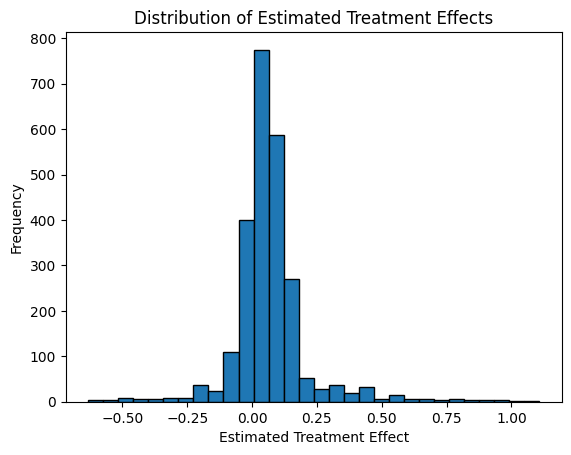

In [18]:
import matplotlib.pyplot as plt
plt.hist(treatment_effects, bins=30, edgecolor='k')
plt.title('Distribution of Estimated Treatment Effects')
plt.xlabel('Estimated Treatment Effect')
plt.ylabel('Frequency')
plt.show()

In [19]:
covariates = ['l_online_pay_doc_num_m_ln', 'l_online_pay_doc_length_m_ln',
       'l_online_pay_speed_p', 'l_on2off_ln', 'l_review_ln', 'l_rating_cum',
       'l_article_ln', 'month_12_2', 'month_12_3', 'month_12_4', 'month_12_5',
       'month_12_6', 'month_12_7', 'month_12_8', 'month_12_9', 'month_12_10',
       'month_12_11', 'month_12_12', 'year_2013', 'year_2014', 'year_2015',
       'year_2016', 'year_2017']

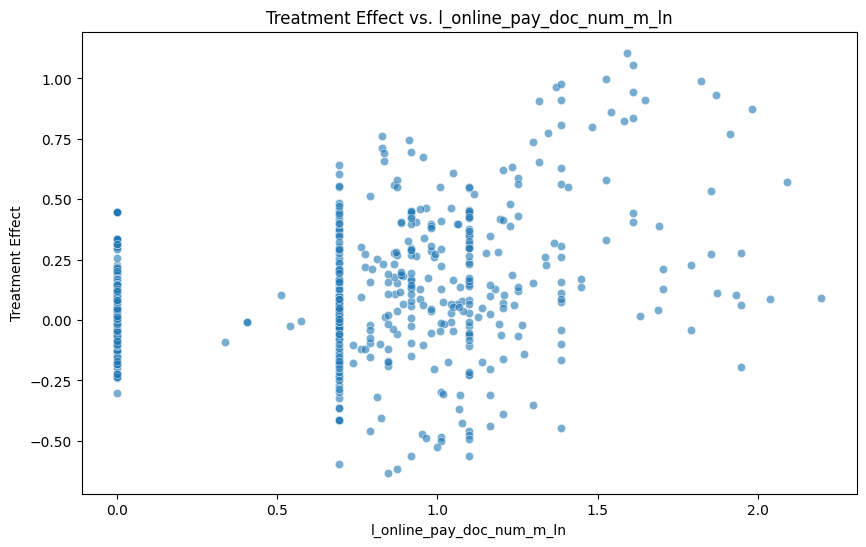

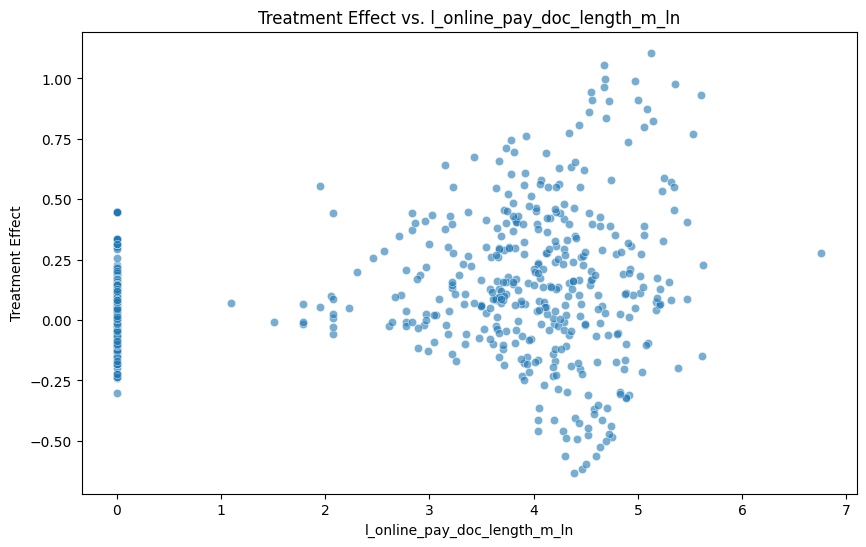

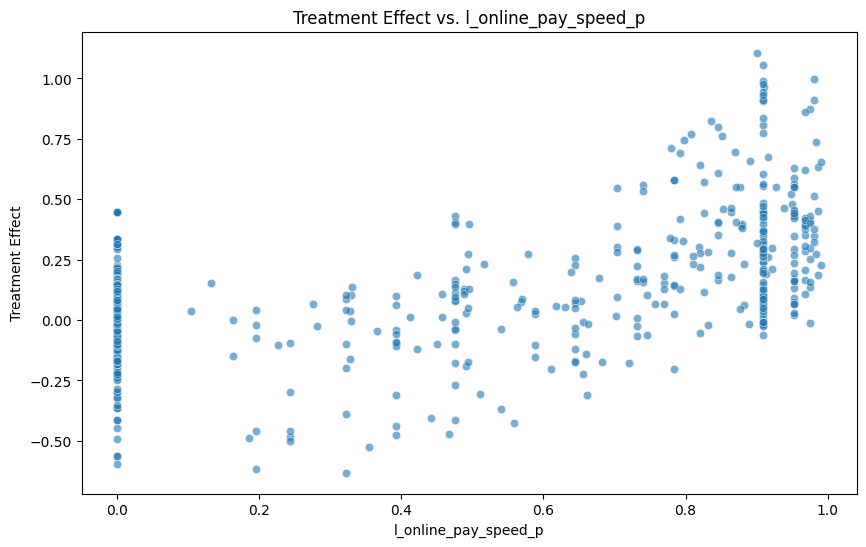

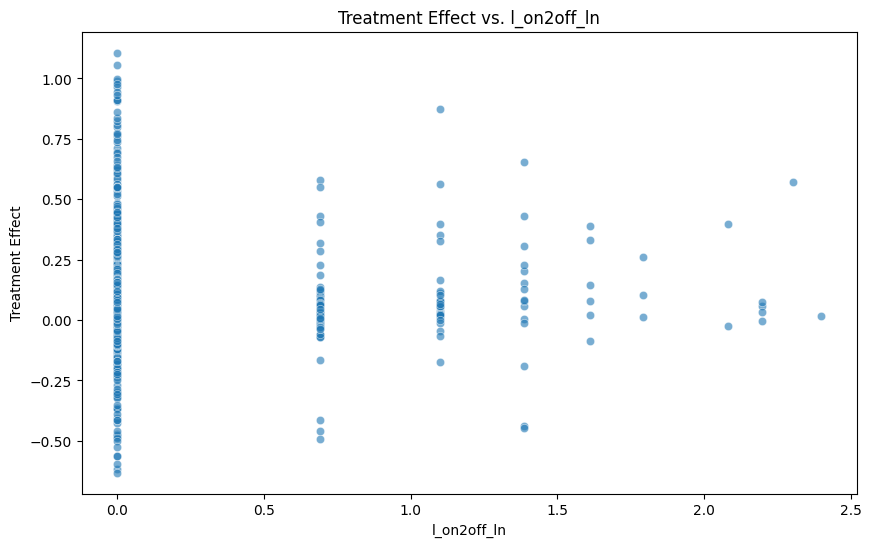

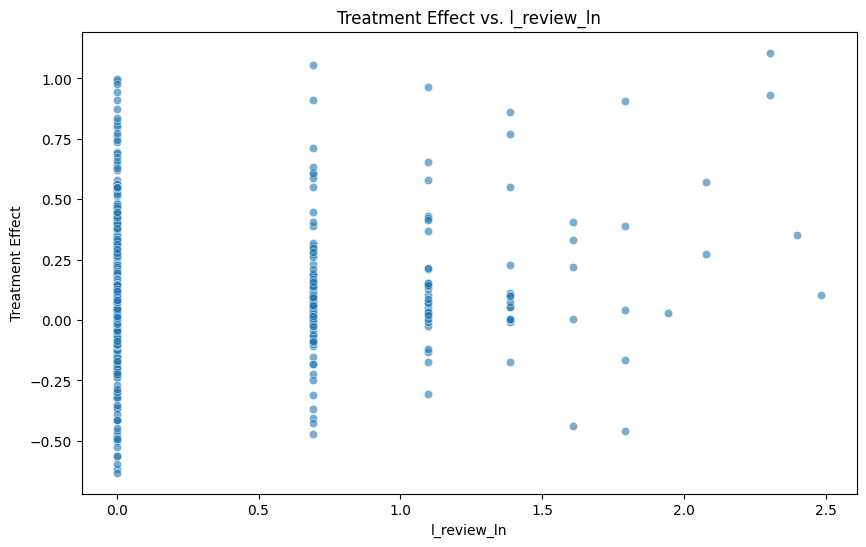

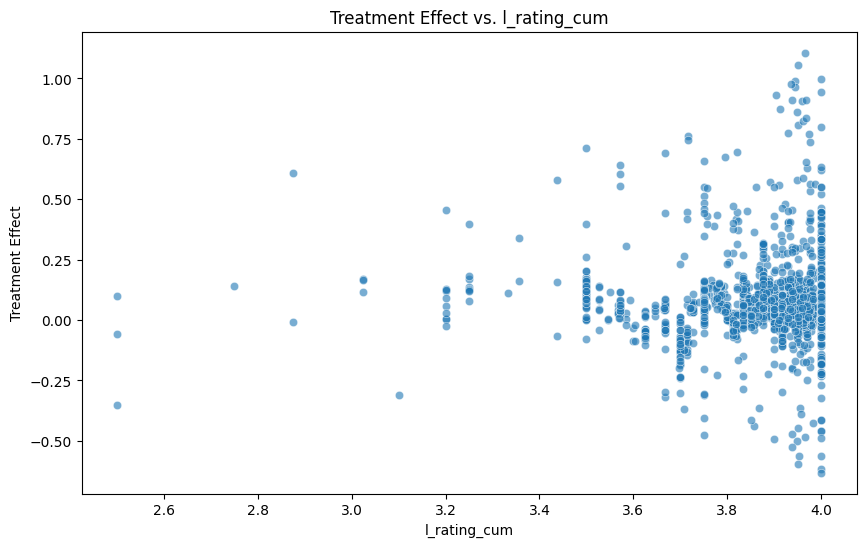

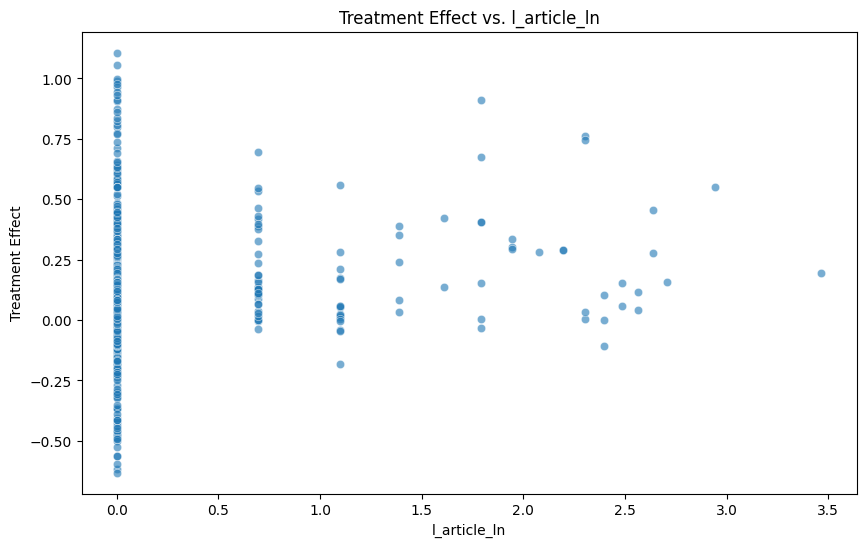

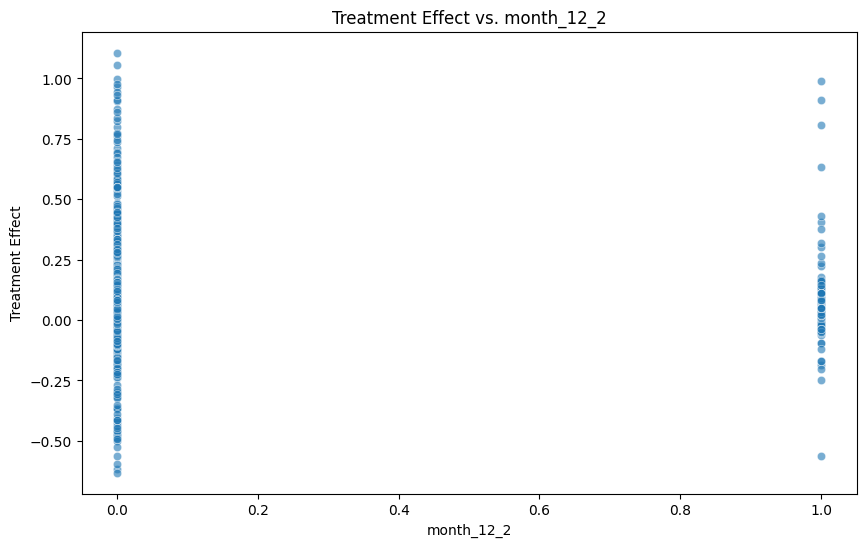

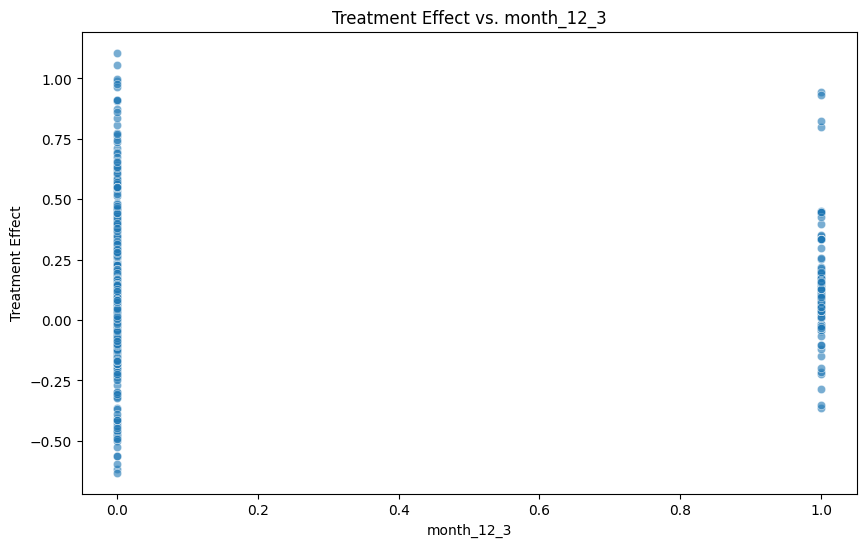

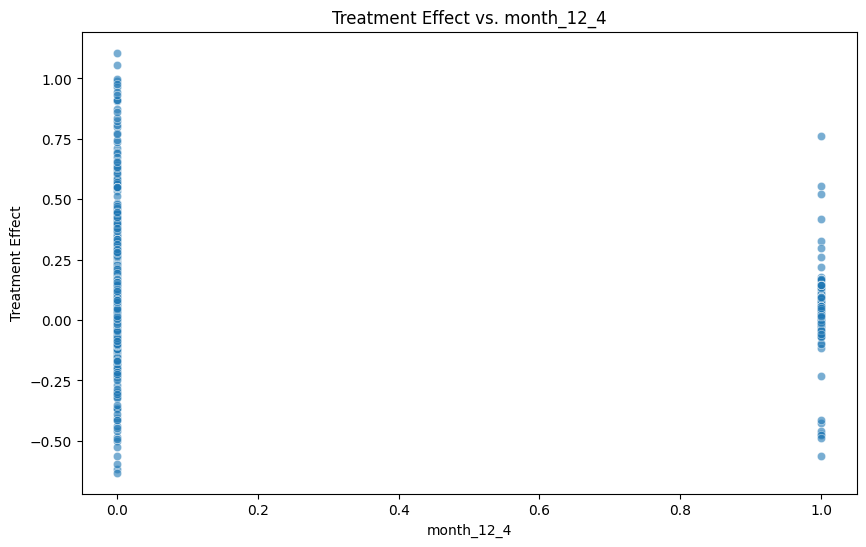

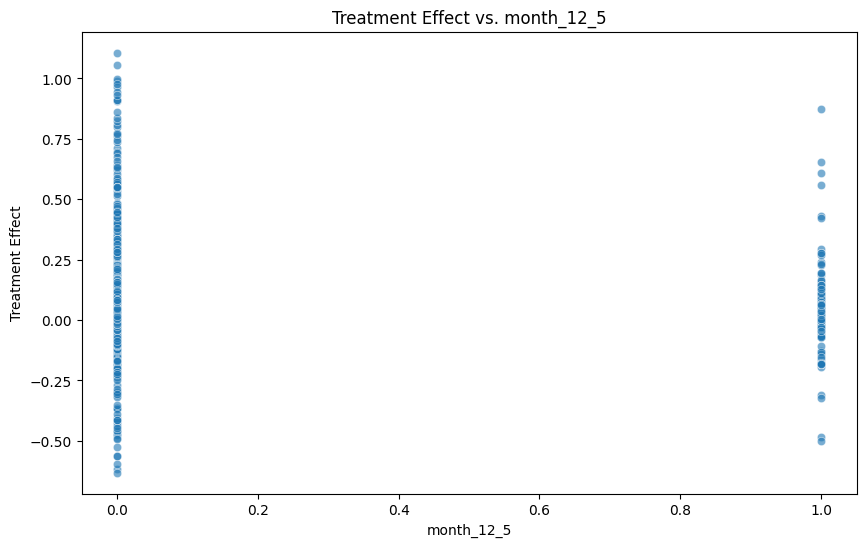

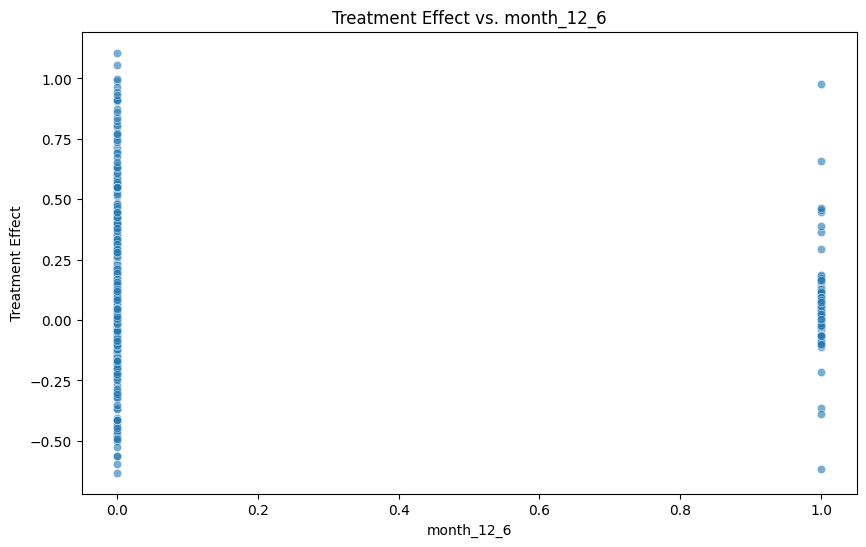

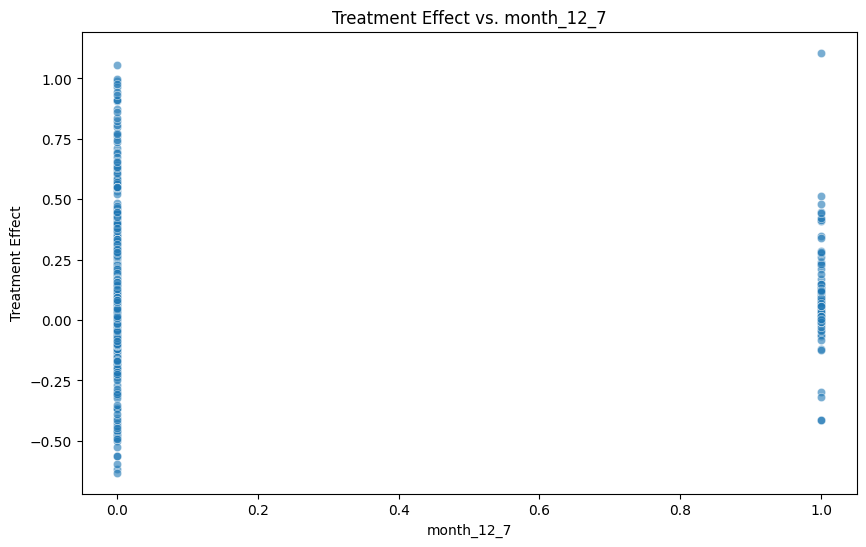

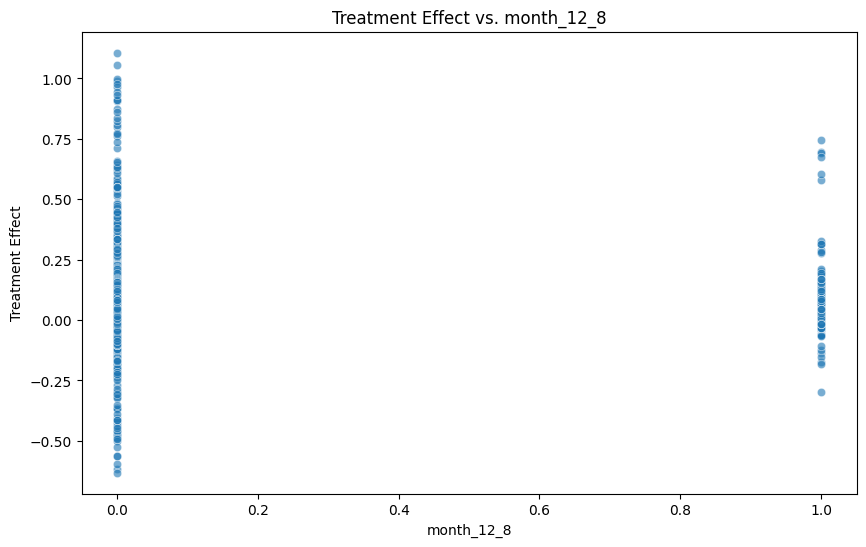

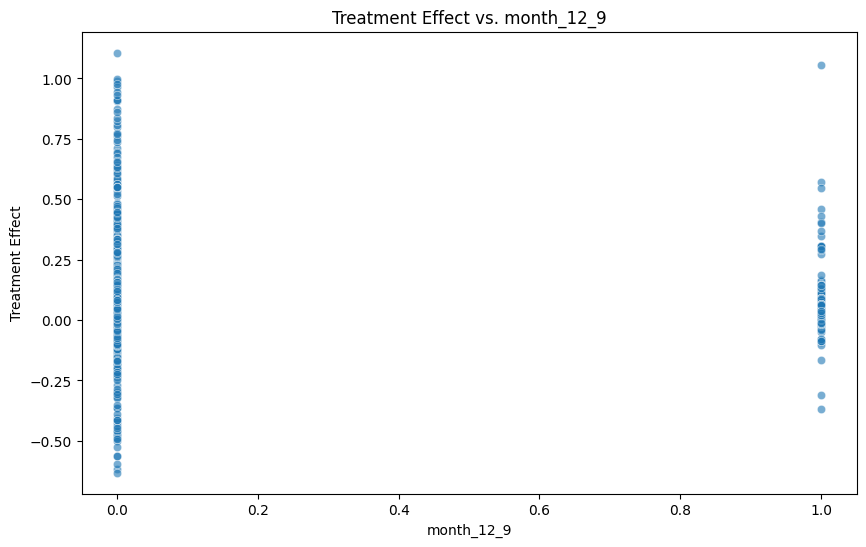

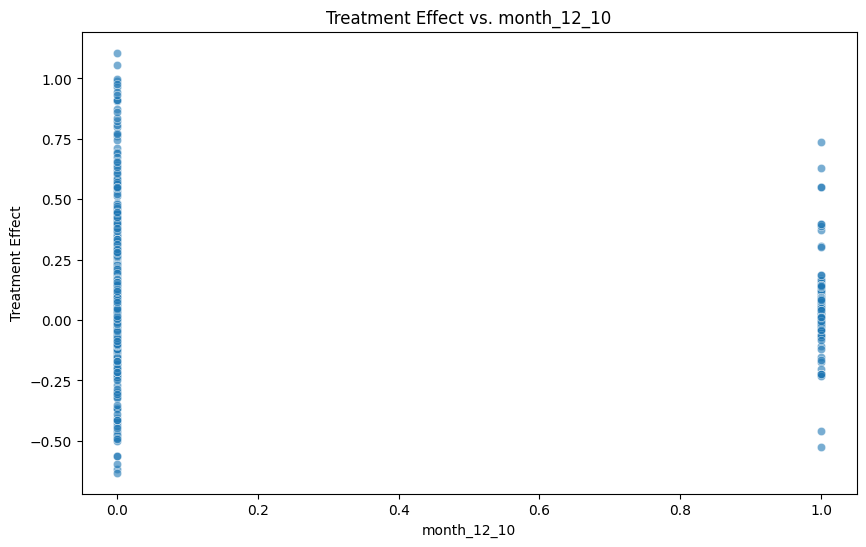

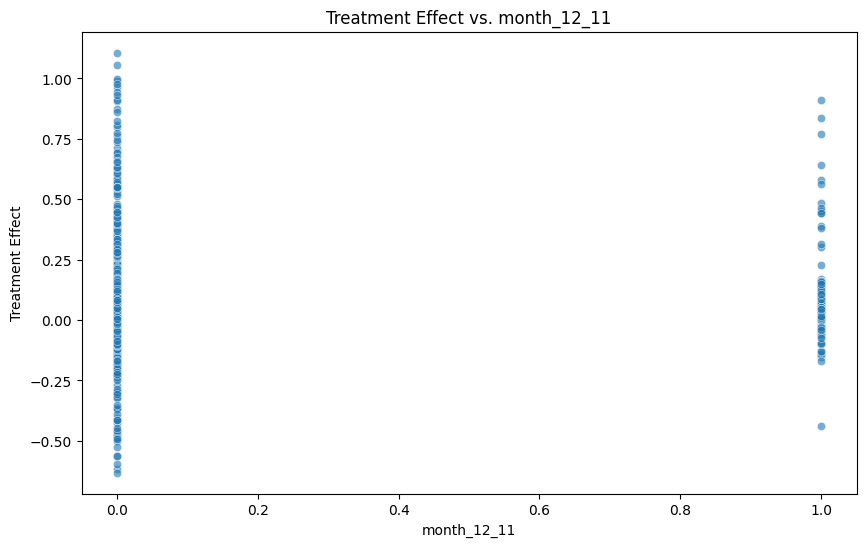

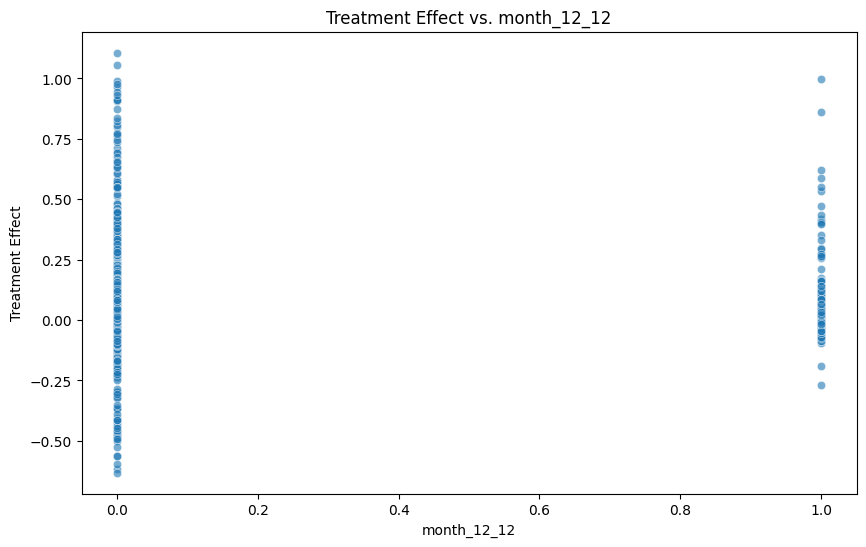

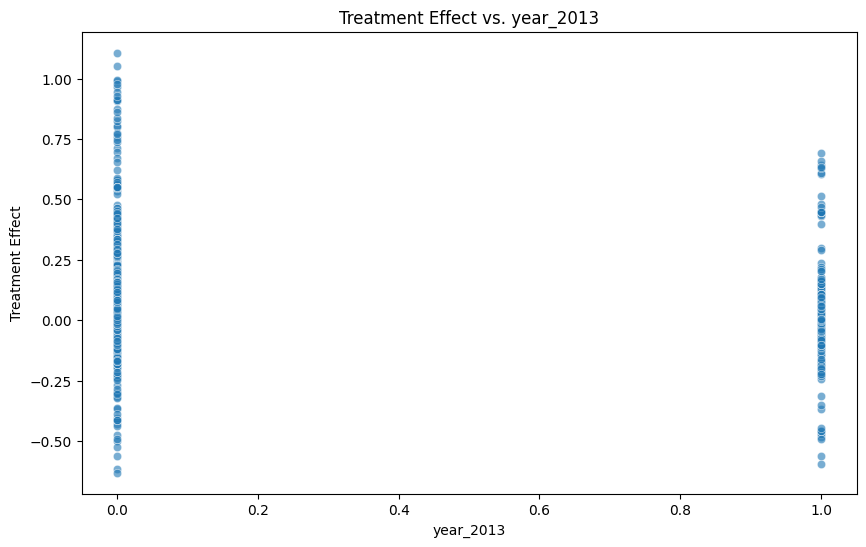

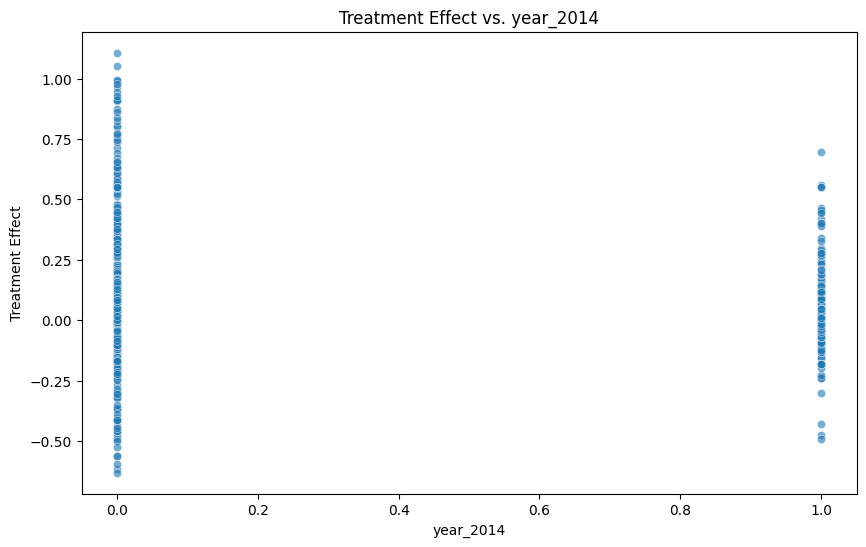

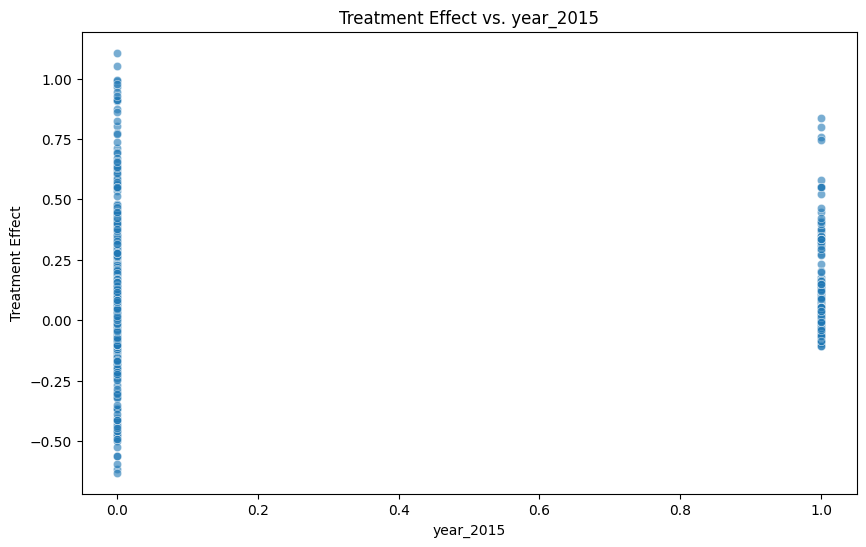

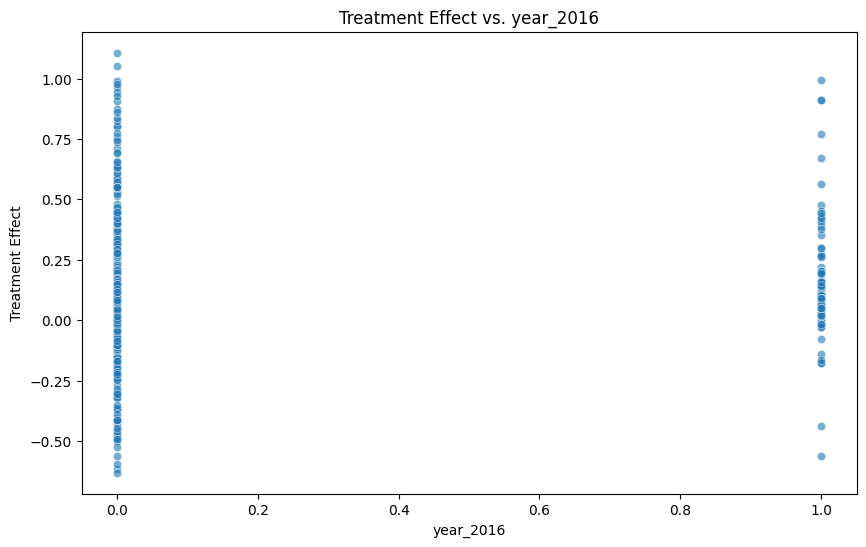

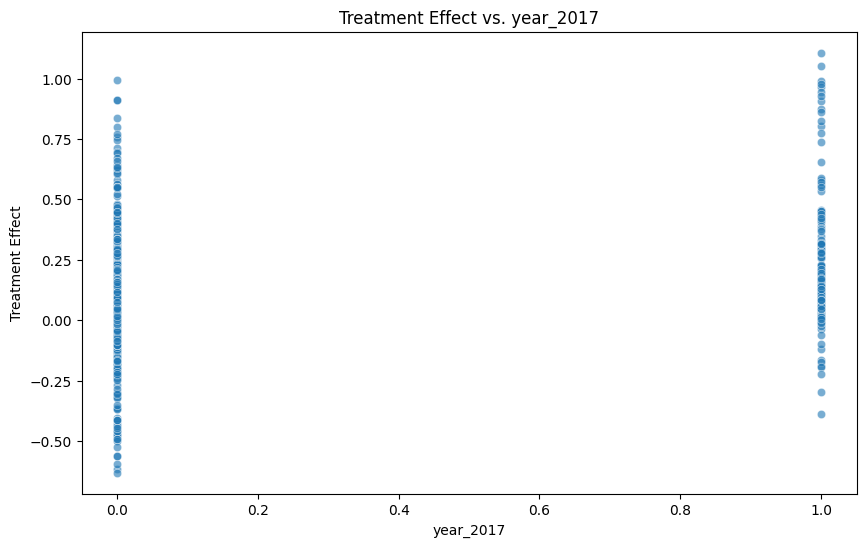

In [20]:
# Create a DataFrame for plotting
plot_data = pd.DataFrame(X_test, columns=covariates)
plot_data['Treatment Effect'] = treatment_effects
plot_data["doc_adoption"] = test["doc_adoption"].values
plot_data["year"] = test["year"].values
plot_data["month"] = test["month_12"].values

# Scatter plot for each covariate
for covariate in covariates:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=plot_data, x=covariate, y='Treatment Effect', alpha=0.6)
    plt.title(f'Treatment Effect vs. {covariate}')
    plt.xlabel(covariate)
    plt.ylabel('Treatment Effect')
    plt.show()
